In [63]:
import pandas as pd
import numpy as np
from random import choices
from collections import Counter


def get_optimised_electrolyser_demand(
    elec_price,
    dispenser_time_demand,
    starting_storage_level,
    electrolyser_capacity,
    storage_capacity,
):
    """
    Inputs:
        elec_price : numpy array of size 48 containing the half hourly electricity prices for that day.

        dispenser_time_demand : numpy array of varying size that contains (in order) the time at which each HGV
                                is arriving i.e. for a HGV arriving at 2am, 10am and 6pm == [4,20,32].

        starting_storage_level : a number (float) that states how much Hydrogen there is at 00:00 before the 
                                 optimisation starts.

    Outputs:
        final_electrolyser_demand : numpy array of size 48 containing the optimised electrolyers demand for the 
                                    following 24 hrs.

        post_hgv_storage_level[z] : the ending storage level that can then be added into the stations self
                                    or input elsewhere.
    """

    # determines if the demand can be met
    unsatisfied = 0

    # Turns dispenser_time_demand into hydrogen demand
    dispenser_demand = np.zeros(48)
    for z in range(len(dispenser_time_demand)):
        dispenser_demand[dispenser_time_demand[z]] += 1
    dispenser_demand = dispenser_demand * 32.09

    # Initialises Vectors
    pre_hgv_storage_level = np.zeros(48)
    post_hgv_storage_level = np.zeros(48)
    final_electrolyser_demand = np.zeros(48)

    # Starts the Optimisation
    for z in range(48):

        # ____________________________________________________________________________
        # Loop for every z iteration
        # ____________________________________________________________________________

        electrolyser_demand = np.zeros(48)

        # Setting the Storage level for each hgv iteration
        if z == 0:
            storage_level = starting_storage_level
        else:
            storage_level = post_hgv_storage_level[z - 1]

        for q in range(len(dispenser_time_demand)):

            # _______________________________________________________________________
            # Loop for every HGV
            # _______________________________________________________________________

            count = 0
            for k in range(len(dispenser_time_demand)):
                if dispenser_time_demand[k] >= z:
                    count += 1

            temp = q - (len(dispenser_time_demand) - count)

            if temp >= 0:
                h2_needed = max(((temp + 1) * 32.09 - storage_level), 0)
            else:
                h2_needed = 0

            small_array = elec_price[z : (dispenser_time_demand[q] + 1)]
            sorted_small_array = np.argsort(small_array)

            for n in range(len(sorted_small_array)):
                index = sorted_small_array[n] + z
                if h2_needed > 0:
                    spare_capacity = min(
                        (electrolyser_capacity - electrolyser_demand[index]),
                        (storage_capacity - storage_level),
                    )

                    if spare_capacity >= h2_needed:
                        electrolyser_demand[index] += h2_needed
                        storage_level += h2_needed
                        h2_needed = 0
                    if h2_needed > spare_capacity:
                        electrolyser_demand[index] += spare_capacity
                        storage_level += spare_capacity
                        h2_needed = h2_needed - spare_capacity

        final_electrolyser_demand[z] = electrolyser_demand[z]
        if z == 0:
            pre_hgv_storage_level[z] = starting_storage_level + electrolyser_demand[z]
        else:
            pre_hgv_storage_level[z] = (
                post_hgv_storage_level[z - 1] + electrolyser_demand[z]
            )
        post_hgv_storage_level[z] = pre_hgv_storage_level[z] - dispenser_demand[z]

        if post_hgv_storage_level[z] < 0:
            unsatisfied += 1

        post_hgv_storage_level[z] = max(post_hgv_storage_level[z], 0)
        pre_hgv_storage_level[z] = max(pre_hgv_storage_level[z], 0)

        hi = Counter(dispenser_time_demand)
        at_one_time = hi.most_common()[0][1]

    return final_electrolyser_demand, pre_hgv_storage_level, unsatisfied, at_one_time


def elec_prices_data(day):

    data = pd.read_csv("Data/agileprices2020.csv")
    temp = data.iloc[day - 1].values
    temp = temp[1::]

    return temp


def get_arrival_times(n_hgv):

    arrival_times = []

    population = [n for n in range(4, 48)]
    weights = []
    for n in range(len(population)):
        weights.append(1)

    for n in range(n_hgv):

        value = choices(population, weights)

        if value[0] == 4:
            weights[value[0] - 4] *= 0.1
            weights[value[0] - 3] *= 0.2
        if value[0] == 47:
            weights[value[0] - 4] *= 0.1
            weights[value[0] - 5] *= 0.2
        else:
            weights[value[0] - 4] *= 0.1
            weights[value[0] - 3] *= 0.2
            weights[value[0] - 5] *= 0.2

        arrival_times.append(value[0])

    arrival_times.sort()

    return arrival_times


"""
_______________________________________________________________________________________________________________________________
"""

"""
_______________________________________________________________________________________________________________________________
"""
"""
_______________________________________________________________________________________________________________________________
"""

"""
_______________________________________________________________________________________________________________________________
"""

# total_ROI_array = np.zeros(100)

# for p in range(len(total_ROI_array)):

# n_hgv = p + 1
n_hgv = 100
# print(n_hgv)

array_arrival_times = np.zeros([365, n_hgv])
for q in range(365):
    array_arrival_times[q] = get_arrival_times(n_hgv)
array_arrival_times = array_arrival_times.astype(int)

ROI_array = np.zeros([5, 300])

for i in range(len(ROI_array)):
    for j in range(len(ROI_array[0])):
        
        print(n_hgv, i, j)

        n_electrolysers = i + 1
        n_canisters = j + 1

        electrolyser_capacity = n_electrolysers * 22.125
        storage_capacity = n_canisters * 9.5

        average_cost = np.zeros(365)
        unsatisfaction = np.zeros(365)
        max_at_one_time = np.zeros(365)
        for n in range(365):

            day = n + 1

            dispenser_time_demand = array_arrival_times[n].tolist()
            elec_price = elec_prices_data(day)
            starting_storage_level = 0

            (
                demand,
                level,
                unsatisfied,
                at_one_time,
            ) = get_optimised_electrolyser_demand(
                elec_price,
                dispenser_time_demand,
                starting_storage_level,
                electrolyser_capacity,
                storage_capacity,
            )

            # convert from kg to kWh
            demand = demand * 51.38
            # convert to pounds
            elec_price = elec_price / 100

            cost = np.dot(demand, elec_price)

            average_cost[n] = cost / len(dispenser_time_demand)
            unsatisfaction[n] = unsatisfied
            max_at_one_time[n] = at_one_time

            if unsatisfied >= 1:
                break

        yearly_avg_cost = np.average(average_cost)

        if np.sum(unsatisfaction) > 0:
            feasible = 0
        else:
            feasible = 1

        electrolyser_cost = 3475000 * n_electrolysers
        heat_exchanger_cost = 110000
        hydrogen_canister_cost = 24000 * n_canisters
        dispenser_cost = 90000 * np.max(max_at_one_time)
        hgv_cost = n_hgv * 55000

        capital_cost = (
            electrolyser_cost
            + heat_exchanger_cost
            + hydrogen_canister_cost
            + dispenser_cost
            + hgv_cost
        )
        yearly_return = (
            (169.36 - yearly_avg_cost) * len(dispenser_time_demand) * 365
        )

        if feasible == 1:
            ROI = (yearly_return / capital_cost) * 100
        else:
            ROI = 0

        ROI_array[i][j] = ROI

#     total_ROI_array[p] = np.max(ROI_array)

"""
_____________________________________________________________________________________________________________________
"""

# df = pd.DataFrame(total_ROI_array)
# df.to_csv("Results.csv")

# df2 = pd.DataFrame(array_arrival_times)
# df2.to_csv("Arrivals.csv")



100 0 0
100 0 1
100 0 2
100 0 3
100 0 4
100 0 5
100 0 6
100 0 7
100 0 8
100 0 9
100 0 10
100 0 11
100 0 12
100 0 13
100 0 14
100 0 15
100 0 16
100 0 17
100 0 18
100 0 19
100 0 20
100 0 21
100 0 22
100 0 23
100 0 24
100 0 25
100 0 26
100 0 27
100 0 28
100 0 29
100 0 30
100 0 31
100 0 32
100 0 33
100 0 34
100 0 35
100 0 36
100 0 37
100 0 38
100 0 39
100 0 40
100 0 41
100 0 42
100 0 43
100 0 44
100 0 45
100 0 46
100 0 47
100 0 48
100 0 49
100 0 50
100 0 51
100 0 52
100 0 53
100 0 54
100 0 55
100 0 56
100 0 57
100 0 58
100 0 59
100 0 60
100 0 61
100 0 62
100 0 63
100 0 64
100 0 65
100 0 66
100 0 67
100 0 68
100 0 69
100 0 70
100 0 71
100 0 72
100 0 73
100 0 74
100 0 75
100 0 76
100 0 77
100 0 78
100 0 79
100 0 80
100 0 81
100 0 82
100 0 83
100 0 84
100 0 85
100 0 86
100 0 87
100 0 88
100 0 89
100 0 90
100 0 91
100 0 92
100 0 93
100 0 94
100 0 95
100 0 96
100 0 97
100 0 98
100 0 99
100 0 100
100 0 101
100 0 102
100 0 103
100 0 104
100 0 105
100 0 106
100 0 107
100 0 108
100 0 109
100 0 110


100 2 253
100 2 254
100 2 255
100 2 256
100 2 257
100 2 258
100 2 259
100 2 260
100 2 261
100 2 262
100 2 263
100 2 264
100 2 265
100 2 266
100 2 267
100 2 268
100 2 269
100 2 270
100 2 271
100 2 272
100 2 273
100 2 274
100 2 275
100 2 276
100 2 277
100 2 278
100 2 279
100 2 280
100 2 281
100 2 282
100 2 283
100 2 284
100 2 285
100 2 286
100 2 287
100 2 288
100 2 289
100 2 290
100 2 291
100 2 292
100 2 293
100 2 294
100 2 295
100 2 296
100 2 297
100 2 298
100 2 299
100 3 0
100 3 1
100 3 2
100 3 3
100 3 4
100 3 5
100 3 6
100 3 7
100 3 8
100 3 9
100 3 10
100 3 11
100 3 12
100 3 13
100 3 14
100 3 15
100 3 16
100 3 17
100 3 18
100 3 19
100 3 20
100 3 21
100 3 22
100 3 23
100 3 24
100 3 25
100 3 26
100 3 27
100 3 28
100 3 29
100 3 30
100 3 31
100 3 32
100 3 33
100 3 34
100 3 35
100 3 36
100 3 37
100 3 38
100 3 39
100 3 40
100 3 41
100 3 42
100 3 43
100 3 44
100 3 45
100 3 46
100 3 47
100 3 48
100 3 49
100 3 50
100 3 51
100 3 52
100 3 53
100 3 54
100 3 55
100 3 56
100 3 57
100 3 58
100 3 59


KeyboardInterrupt: 

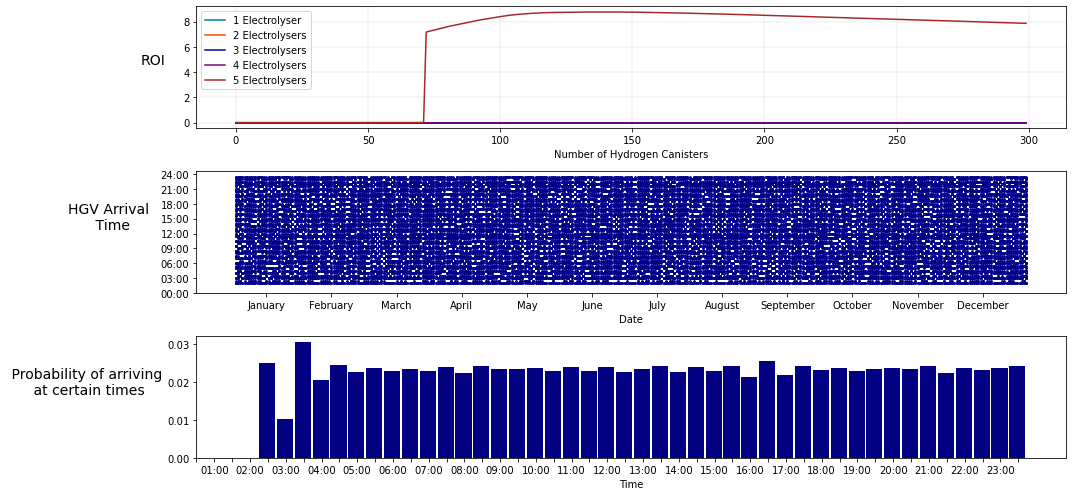

In [92]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, figsize=[15,7])

x1 = [n for n in range(1,366)]


ax[0].plot(ROI_array[0], color='teal', label='1 Electrolyser')
ax[0].plot(ROI_array[1], color='orangered', label='2 Electrolysers')
ax[0].plot(ROI_array[2], color='darkblue', label='3 Electrolysers')
ax[0].plot(ROI_array[3], color='purple', label='4 Electrolysers')
ax[0].plot(ROI_array[4], color='brown', label='5 Electrolysers')
ax[0].set_ylabel('ROI', rotation=0, fontsize=14, labelpad=30)
ax[0].set_xlabel('Number of Hydrogen Canisters')
ax[0].grid(lw=0.2)
ax[0].legend()

for n in range(n_hgv):
    ax[1].scatter(x1, array_arrival_times[:,n], s=3, color='darkblue')

my_xticks = [n for n in range(15,370,30)]
my_xticks_names = ['January','February','March','April','May','June','July','August','September','October','November','December']
ax[1].set_xticks(my_xticks)
ax[1].set_xticklabels(my_xticks_names)
my_yticks = [n for n in range(0,50,6)]
my_yticks_names = ['00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00','24:00']
ax[1].set_yticks(my_yticks)
ax[1].set_yticklabels(my_yticks_names)
ax[1].set_ylabel('HGV Arrival \n Time', rotation=0, labelpad=50,fontsize=14)
ax[1].set_xlabel('Date')

for n in range(n_hgv-3):
    if n==0:
        new = np.append(array_arrival_times[:,n], array_arrival_times[:,n+1])
    else:
        new = np.append(new, array_arrival_times[:,n+1])   
    
ax[2].hist(new, bins=[n for n in range(4,48)],width=0.9, align='right', density=True, color='navy')
my_xticks = [n for n in range(1,48,1)]
my_xtick_labels = ['','01:00','','02:00','','03:00','','04:00','','05:00','','06:00','','07:00','','08:00','','09:00','','10:00','','11:00','','12:00','','13:00','','14:00','','15:00','','16:00','','17:00','','18:00','','19:00','','20:00','','21:00','','22:00','','23:00','']
ax[2].set_xticks(my_xticks)
ax[2].set_xticklabels(my_xtick_labels)
ax[2].set_ylabel('\n Probability of arriving \n at certain times', rotation=0, labelpad=80,fontsize=14)
ax[2].set_xlabel('Time')

fig.tight_layout()

# print(np.max(ROI_array[4]))

plt.show()

In [94]:
np.max(ROI_array[4])

8.760606245471868

In [121]:
ROI_array[4][139]

8.760606245471868

In [126]:
ROI_array[4][72]

7.170754829535503